In [1]:
import subprocess
import pdb

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from nilearn.plotting import view_img_on_surf, view_img
from scipy.stats import ttest_1samp

import networkx as nx
from IPython.display import HTML

# import nest_asyncio
# nest_asyncio.apply()
# import datalad.api as dl

import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import scipy.io
from scipy import stats

from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance
from sklearn.preprocessing import RobustScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime as dt
from scipy.signal import hilbert, butter, filtfilt
from kuramoto import Kuramoto, plot_phase_coherence, plot_activity

from tqdm import tqdm
from multiprocess import Pool



%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")


/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.

Autosaving every 5 seconds


Autosaving every 5 seconds


In [2]:
labels = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/labels.csv'
bbasepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base'
clamppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp'
ppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/'

# Important functions

In [3]:
def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub][roi]
    return pd.DataFrame(sub_rois)

# Read in the total_ts files generated in the synchronicity analysis notebook

In [4]:
sub_timeseries_w_na = {}
for txtfile in glob.glob(os.path.join(clamppath,'*','total_ts.csv')):
    print(txtfile)
    df = pd.read_csv(txtfile)
    sub = txtfile.split('/')[-2]
    df = df.set_index('time')
    df = df.drop(['PBP','VTA','SNr','glucose_mg_dL'], 1)
    sub_timeseries_w_na[sub] = df


/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20008/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20004/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20010/total_ts.csv


In [5]:
heady = list(sub_timeseries_w_na['20001'].columns.values)

In [94]:
base_ts = {}
for x in heady:
    base_ts[x] = get_subject_roi(sub_timeseries_w_na, '%s'%x).dropna()
    

In [95]:
base_ts.keys()

dict_keys(['Pu', 'Ca', 'NAC', 'EXA', 'GPe', 'GPi', 'SNc', 'RN', 'VeP', 'HN', 'HTH', 'MN', 'STH', 'dlPFC', 'Viz', 'Hippo', 'insulin_uIU_mL'])

# Null models

## Phase Randomization
Going to use phase randomization to generate a randome surrogate of the data. This should maintain the temporal and autoregressive structure of the data. Will need to figure out how to do this with the insulin data

### Function to randomize the data

In [66]:
def so_random(roi):
    randoms = {roi: {}}
    subs = list(base_ts[roi].columns)
    for sub in subs:
        sub_rois = base_ts[roi][sub]
        it = list(range(0, 50000))
        so_ran = []
        for x, y in enumerate (it): 
            so_ran.append(phase_randomize(sub_rois))
        randoms[roi][sub] = np.mean(so_ran, axis=0)
    return(randoms)

### Run the randomization in parallel 
Here I generate 50,000 randomized dataframes and take the mean of the randomized dataframes at the end

In [96]:
max_pool = 5
# subs = list(sub_timeseries.keys())
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(p.imap(so_random, heady),total=len(heady)))    

total_null ={}
for x in pool_outputs:
    key, value = list(x.items())[0]
    total_null[key] = value

100%|███████████████████████████████████████████| 17/17 [00:44<00:00,  2.65s/it]


In [97]:
nullz = {}
for roi, dat in total_null.items():
    df = pd.DataFrame.from_dict(dat)
    df['time'] = base_ts[roi].index
    df = df.set_index('time')
    nullz[roi] = df

# Null Time syncrony
This is the meat of the analysis stream, here we will calculated the synchonicity between each subject's roi and insulin.  
https://naturalistic-data.org/content/Intersubject_Correlation.html#intersubject-phase-synchrony-tutorial

## Custom functions
These aren't all custom, but I did break apart several existing functions to cobble them back together how I wanted

In [33]:
def _phase_vector_length_sine_only(phase_angles):
    """
    Only going to get the sine of the phase_angles
    Compute vector length of phase angles using circular statistics

    Can take 1D (observation for a single feature) or 2D (observation x feature) signals

    Implementation from:

        Fisher, N. I. (1995). Statistical analysis of circular data. cambridge university press.

    Args:
        phase_angles: (np.array) 1D or 2D array of phase angles

    Returns:
         phase angle vector length: (np.array)

    """

    axis = 0 if len(phase_angles.shape) == 1 else 1
    return np.float32(
#             np.mean(np.cos(phase_angles), axis=axis) ** 2 +
              np.mean(np.sin(phase_angles), axis=axis))

In [34]:
def b_bandpass_filter(data, low_cut, high_cut, fs, axis=0, order=5):
    """
    Apply a bandpass butterworth filter with zero-phase filtering

    Args:
        data: (np.array)
        low_cut: (float) lower bound cutoff for high pass filter
        high_cut: (float) upper bound cutoff for low pass filter
        fs: (float) sampling frequency in Hz
        axis: (int) axis to perform filtering.
        order: (int) filter order for butterworth bandpass

    Returns:
        bandpass filtered data.
    """
    nyq = 0.5 * fs
    b, a = butter(order, [low_cut / nyq, high_cut / nyq], btype="band")
    return filtfilt(b, a, data, axis=axis)

In [35]:
def isps_insulin(data, pairwise=False):
    #Updated with sine only phase 
    if not isinstance(data, (pd.DataFrame, np.ndarray)):
        raise ValueError("data must be a pandas dataframe or numpy array (observations by subjects)")
    phase = np.angle(hilbert(pd.DataFrame(data), axis=0))
    out = {"average_angle": _phase_mean_angle(phase)}
    out["vector_length"] = _phase_vector_length_sine_only(phase)
    return out


In [138]:
def _phase_rayleigh_p(phase_angles):
    """Compute the p-value of the phase_angles using the Rayleigh statistic

    Note: this test assumes every time point is independent, which is unlikely to be true in a timeseries with autocorrelation

    Implementation from:

        Fisher, N. I. (1995). Statistical analysis of circular data. cambridge university press.

    Args:
        phase_angles: (np.array) 1D or 2D array of phase angles

    Returns:
         p-values: (np.array)

    """

    n = len(phase_angles) if len(phase_angles.shape) == 1 else phase_angles.shape[1]

    Z = n * _phase_vector_length(phase_angles) ** 2
    if n <= 50:
        return np.exp(-1 * Z) * (
            1
            + (2 * Z - Z ** 2) / (4 * n)
            - (24 * Z - 132 * Z ** 2 + 76 * Z ** 3 - 9 * Z ** 4) / (288 * n ** 2)
        )
    else:
        return np.exp(-1 * Z)

## About frequencies 
See the synchronicity notebook 

## Get the phases of the rois
This will get the phases for each roi per subject. This is using a bandpass filter and the hilbert transform in line with previous methods. 

In [101]:
rois = list(nullz.keys())[:-1]

In [103]:
null_phaze = {}
tr = 1
time = {}
out = {}
frequencies = [(0.021, 0.036),(0.063, 0.098),(0.13, 0.17),(0.2, 0.25)]
frq = ['IMF4: 0.021–0.036 Hz','IMF3: 0.063–0.098 Hz','IMF2: 0.13–0.17 Hz','IMF1: 0.20–0.25 Hz']
rois = list(nullz.keys())[:-1]
for roi in rois:
    time[roi] = nullz[roi].index
    subs = list(nullz[roi].columns)
    null_phaze[roi] = {}
    for sub in subs:
        null_phaze[roi][sub]={}
        for x, freq in enumerate(frequencies):
            null_phaze[roi][sub][frq[x]] = np.angle(
                hilbert(b_bandpass_filter(nullz[roi][sub], low_cut=freq[0], high_cut=freq[1], fs=1/tr, order=5), 
                        axis=0,))



In [123]:
n_phaze = {}
for roi, dat in null_phaze.items():
    n_phaze[roi] = {}
    for sub, data in dat.items():
        df =  pd.DataFrame.from_dict(data)
        df['time'] = nullz[roi].index
        df = df.set_index('time')
        n_phaze[roi][sub] = df
        

## Get insulin phase
This is a hilbert transform to smooth the insulin time series. This produces a smooth insulin curve per subject. We will refer to this as the phase

In [108]:
null_insulin_df = nullz['insulin_uIU_mL']
subs = null_insulin_df.columns
null_in_sync = {}
for x in subs:
    null_in_sync[x] = np.angle(hilbert(null_insulin_df[x], axis=0))
n_sync = pd.DataFrame.from_dict(null_in_sync)
n_sync['time'] = nullz['insulin_uIU_mL'].index
n_sync = n_sync.set_index('time')

## Get the phase vector length of insulin and ROI
Initially I did this all combined
~~Here we combine the smoothed insulin phases and the filtered and smoothed ROI phases on a per ROI bases. This means the 4 insulin curves (1 per subject) are combined with the 4 ROI curves (1 per subject). We then calculate the phase vector length. A small phase vector length means the curves are not similar, a large phase vector length means the curves are in the same direction. ~~

### What I actually did
Going to do this pairwise with 1 insulin curve and 1 ROI persubject

In [170]:
null_faze = {}
null_p_faze = {}
null_kura = {}
timez = {}
for roi,subs in n_phaze.items():
    print(roi)
    null_faze[roi]={}
    null_p_faze[roi]={}
    null_kura[roi]={}
    timez[roi]={}
    for sub, freq in subs.items():
        print(sub)
        null_faze[roi][sub]={}
        null_p_faze[roi][sub]={}
        null_kura[roi][sub]={}
        timez[roi][sub]={}
        for hz, df in freq.items():
            null_allphase = pd.DataFrame(df).join(pd.DataFrame(n_sync[sub]))
            null_allphase = null_allphase.dropna()
            timez[roi][sub][hz]= null_allphase.index
            null_allphase = np.reshape(null_allphase, (40,2))
#             pdb.set_trace()
            null_allphase = null_allphase[['%s'%hz, '%s'%sub]].to_numpy()
            null_kura[roi][sub][hz] = [Kuramoto.phase_coherence(vec) for vec in null_allphase]
            null_out = {"average_angle": _phase_mean_angle(null_allphase)}
            null_faze[roi][sub][hz]=_phase_vector_length_sine_only(null_allphase)
            null_p_faze[roi][sub][hz] = _phase_rayleigh_p(null_allphase)

Pu
20008
20001
20002
20003
20004
20010
Ca
20008
20001
20002
20003
20004
20010
NAC
20008
20001
20002
20003
20004
20010
EXA
20008
20001
20002
20003
20004
20010
GPe
20008
20001
20002
20003
20004
20010
GPi
20008
20001
20002
20003
20004
20010
SNc
20008
20001
20002
20003
20004
20010
RN
20008
20001
20002
20003
20004
20010
VeP
20008
20001
20002
20003
20004
20010
HN
20008
20001
20002
20003
20004
20010
HTH
20008
20001
20002
20003
20004
20010
MN
20008
20001
20002
20003
20004
20010
STH
20008
20001
20002
20003
20004
20010
dlPFC
20008
20001
20002
20003
20004
20010
Viz
20008
20001
20002
20003
20004
20010
Hippo
20008
20001
20002
20003
20004
20010


In [172]:
n_faze = {}
frq = 'IMF3: 0.063–0.098 Hz'

for roi, dat in null_faze.items():
    n_faze[roi] = {}
    for sub, data in dat.items():
        df =  pd.DataFrame.from_dict(data)
        df['time'] = timez[roi][sub][frq]
        df = df.set_index('time')
        n_faze[roi][sub] = df
        

In [179]:
n_kura = {}
frq = 'IMF3: 0.063–0.098 Hz'

for roi, dat in null_kura.items():
    n_kura[roi] = {}
    for sub, data in dat.items():
        df =  pd.DataFrame.from_dict(data)
        df['time'] = timez[roi][sub][frq]
        df = df.set_index('time')
        n_kura[roi][sub] = df


## Plots of phase similarity
These plots show the similarity between the insulin and ROI curves at different frequency bands of the ROI signal (we are assuming there is only a single band of insulin). Yellow indicates high syncronicity and black means no syncronicity. The larger bands show little similarity and are usually "noise"

In [163]:
frq = 'IMF3: 0.063–0.098 Hz'
roi = 'HTH'

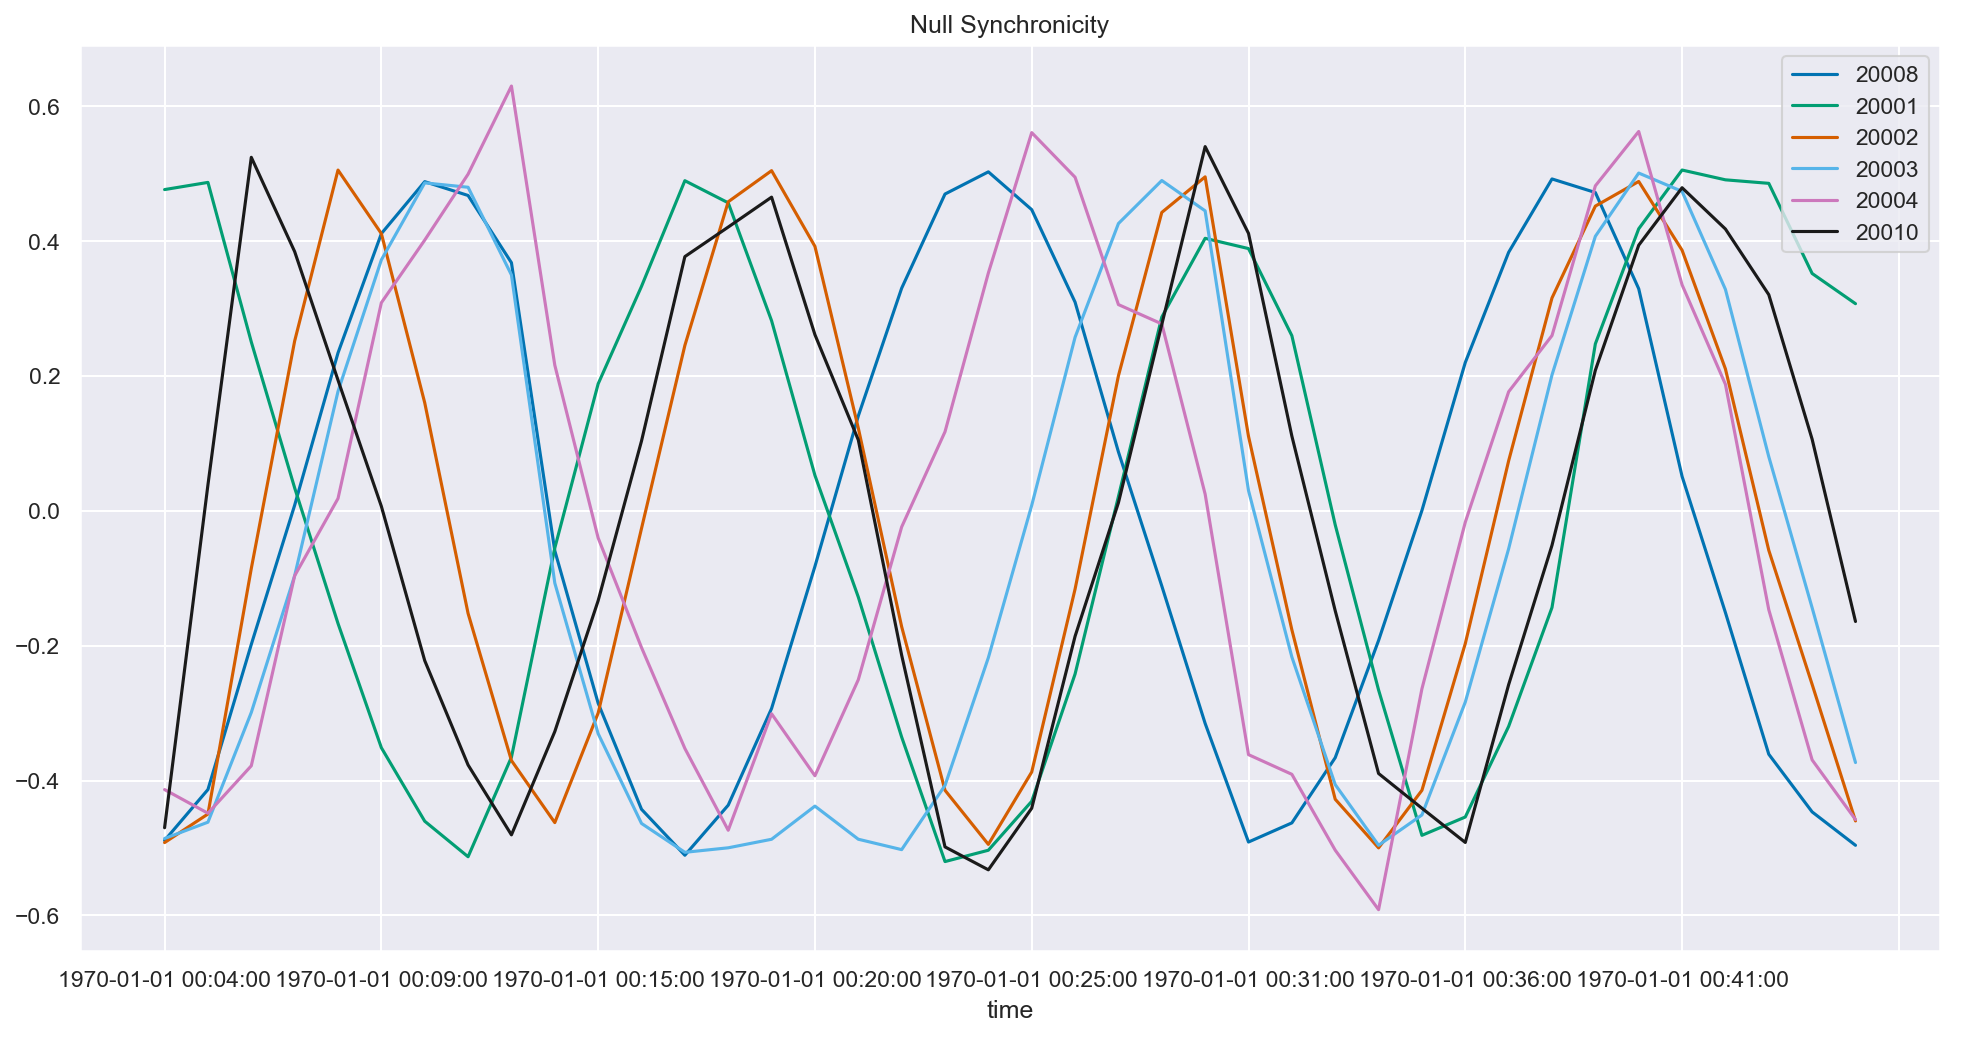

In [188]:
plt.figure(figsize=(16, 8), dpi=150)
col = ['b','g','r','c','m','k']
i = 0
for sub, data in n_faze[roi].items():
    data[frq].plot(label='%s'%sub, color = '%s'%col[i])
    i = i +1

# adding title to the plot
plt.title('Null Synchronicity')

# adding Label to the x-axis
plt.xlabel('time')

# adding legend to the curve
plt.legend()

## Saving the data to csv files to make nicer graphs in R

In [153]:
basepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data'

In [189]:
for roi, dat in n_faze.items():
    sync_df = []
    for sub, data in dat.items():
        x = pd.DataFrame.from_dict(data)
        x['sub'] = sub
        sync_df.append(x)
    sync_df = pd.concat(sync_df)
    sync_df.to_csv(os.path.join(basepath,'derivatives','output','dfs','null_sync_%s.csv'%roi))  

In [ ]:
time

In [191]:
for roi, dat in n_kura.items():
    k_df = []
    for sub, data in null_kura[roi].items():
        x = pd.DataFrame.from_dict(data)
        x['sub'] = sub
        x['time'] = x.index
        k_df.append(x)
    kura_df = pd.concat(k_df)
    kura_df.to_csv(os.path.join(basepath,'derivatives','output','dfs','null_kuramoto_%s.csv'%roi))  